In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd # data processing
import numpy as np # linear algebra

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

import timeit # time measure

import sys

print ('Python version ->', sys.version)
print ('Numpy version ->', np.__version__)
print ('Pandas version ->', pd.__version__)

%matplotlib inline

Python version -> 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Numpy version -> 1.17.4
Pandas version -> 0.25.3


# 1.Data set Load

In [0]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# 2. Processing & Engineering

## date

In [0]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [0]:
# 월요일 0 일요일 6

train['weekday'] = train['date'].dt.weekday
test['weekday'] = test['date'].dt.weekday

In [0]:
# 주말이면 0 평일이면 1
# 공휴일을 체크하지 못한 한계점

train['weekend'] = train['weekday'].map(lambda x : 1 if 4>x else 0)
test['weekend'] = test['weekday'].map(lambda x : 1 if 4>x else 0)

date 변수를 datetime형식으로 바꾼 뒤 더미화가 아닌 주말을 0, 평일을 1로 변환한다.

이 때, 요일 별 그룹 평균을 내었을 때 금요일은 토, 일과 비슷한 평균을 보여 금요일도 주말로 포함한다.

## in_out (시외, 시내)

In [0]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

## bus_route_id, station_code, station_name

In [0]:
print('bus_route_id unique : {}'.format(len(train['bus_route_id'].unique())))
print('station_code unique : {}'.format(len(train['station_code'].unique())))
print('station_name unique : {}'.format(len(train['station_name'].unique())))

bus_route_id unique : 613
station_code unique : 3563
station_name unique : 1961


string으로 되어 있는 데이터는 groupby mean을 통하여 scoring을 한다.

station_name은 station_code와 상관관계가 높아질 수 있으므로 이후에 제거한다.

#### bus_route_id scoring

In [0]:
#bus_route_id를 그룹화 하여 18~20_ride 종속변수를 평균낸다. 
train_bus = train[['18~20_ride','bus_route_id']].groupby('bus_route_id').mean().sort_values('18~20_ride').reset_index()

In [0]:
#수치가 낮은것부터 1을 부여하며, 동점일 경우 같은 점수를 부여하고 그다음 그룹부터는 +1을 하여 점수를 부여

bus_rank = train_bus['18~20_ride'].rank(method = 'dense', ascending = True)

In [0]:
bus_num = {}
for i, v in enumerate(bus_rank):
    bus = train_bus['bus_route_id'].iloc[i]
    bus_num[bus] = v

In [0]:
train['bus_route_score'] = train['bus_route_id'].map(bus_num)
test['bus_route_score'] = test['bus_route_id'].map(bus_num)

In [0]:
#test 데이터에 NaN값이 생기는데, 이것은 test데이터에 같은 key가 없으면 NaN값으로 대체된다.
#따라서, 그 경우 우선 train의 중앙값을 가지고와 test의 변수에 대체해준다.

test['bus_route_score'].fillna(train['bus_route_score'].median(),inplace = True)

#### station_code scoring

In [0]:
train_st_code = train[['18~20_ride','station_code']].groupby('station_code').mean().sort_values('18~20_ride').reset_index()
train_st_code.tail()

,station_code,18~20_ride
3558,3290,17.827586
3559,201,22.217617
3560,3350,22.352273
3561,3351,35.000000
3562,1579,52.032258


In [0]:
code_rank = train_st_code['18~20_ride'].rank(method = 'dense', ascending = True)

In [0]:
st_code_num = {}
for i, v in enumerate(code_rank):
    st_code = train_st_code['station_code'].iloc[i]
    st_code_num[st_code] = v

In [0]:
train['station_code_score'] = train['station_code'].map(st_code_num)
test['station_code_score'] = test['station_code'].map(st_code_num)

In [0]:
test['station_code_score'].fillna(train['station_code_score'].median(), inplace = True)

## bus_route_id & station_code scoring

bus_route_id와 station_code를 묶어 scoring

In [0]:
rank_table = train.groupby(['station_code', 'bus_route_id'])[['18~20_ride']].mean().sort_values('18~20_ride').reset_index()
rank_table['station_rank'] = rank_table['18~20_ride'].rank(method = 'dense', ascending = True)

In [0]:
train = pd.merge(train, rank_table[['station_code', 'bus_route_id', 'station_rank']], on=['bus_route_id','station_code'], how='left')
test = pd.merge(test, rank_table[['station_code', 'bus_route_id', 'station_rank']], on=['bus_route_id','station_code'], how='left')

In [0]:
test['station_rank'].fillna(train['station_rank'].median(), inplace = True)

## ride, takeoff

ride와 takoff시간대 총 합

In [0]:
train['8~12_ride'] = train['8~9_ride'] + train['9~10_ride'] + train['10~11_ride'] + train['11~12_ride']
test['8~12_ride'] = test['8~9_ride'] + test['9~10_ride'] + test['10~11_ride'] + test['11~12_ride']

6~7과 7~8은 종속변수와 상관관계가 많이 낮아서 제거

In [0]:
train['total_takeoff'] = train['6~7_takeoff'] + train['7~8_takeoff'] + train['8~9_takeoff'] + train['9~10_takeoff'] + train['10~11_takeoff'] + train['11~12_takeoff']
test['total_takeoff'] = test['6~7_takeoff'] + test['7~8_takeoff'] + test['8~9_takeoff'] + test['9~10_takeoff'] + test['10~11_takeoff'] + test['11~12_takeoff']

ride를 2시간마다 합침

In [0]:
train['6~8_ride']=train['6~7_ride']+train['7~8_ride']
train['8~10_ride']=train['8~9_ride']+train['9~10_ride']
train['10~12_ride']=train['10~11_ride']+train['11~12_ride']

test['6~8_ride']=test['6~7_ride']+test['7~8_ride']
test['8~10_ride']=test['8~9_ride']+test['9~10_ride']
test['10~12_ride']=test['10~11_ride']+test['11~12_ride']

In [0]:
train['6~8_takeoff']=train['6~7_takeoff']+train['7~8_takeoff']
train['8~10_takeoff']=train['8~9_takeoff']+train['9~10_takeoff']
train['10~12_takeoff']=train['10~11_takeoff']+train['11~12_takeoff']

test['6~8_takeoff']=test['6~7_takeoff']+test['7~8_takeoff']
test['8~10_takeoff']=test['8~9_takeoff']+test['9~10_takeoff']
test['10~12_takeoff']=test['10~11_takeoff']+test['11~12_takeoff']

#### data별 8~12 ride 총합 추가 (유동인구가 많은 날이면 종속변수값이 클것이다)

In [0]:
date_group=train['8~12_ride'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['date_sum_pop']=train['date'].map(date_dict)

date_group=test['8~12_ride'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['date_sum_pop']=test['date'].map(date_dict)

In [0]:
date_group=train['total_takeoff'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['date_takeoff_sum_pop']=train['date'].map(date_dict)

date_group=test['total_takeoff'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['date_takeoff_sum_pop']=test['date'].map(date_dict)

#### station별 8~12 ride 총합 추가 (유동인구가 많은 날이면 종속변수값이 클것이다)

In [0]:
code_group=train['8~12_ride'].groupby(by=train['station_code']).sum()
code_dict=code_group.to_dict()
train['code_sum_pop']=train['station_code'].map(code_dict)

code_group=test['8~12_ride'].groupby(by=test['station_code']).sum()
code_dict=code_group.to_dict()
test['code_sum_pop']=test['station_code'].map(code_dict)

In [0]:
code_group=train['total_takeoff'].groupby(by=train['station_code']).sum()
code_dict=code_group.to_dict()
train['code_takeoff_sum_pop']=train['station_code'].map(code_dict)

code_group=test['total_takeoff'].groupby(by=test['station_code']).sum()
code_dict=code_group.to_dict()
test['code_takeoff_sum_pop']=test['station_code'].map(code_dict)

#### date별 시간 구간 ride 총합 추가 (유동인구가 많은 날이면 종속변수값이 클것이다)

In [0]:
date_group=train['6~8_ride'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['6~8ride_sum_pop']=train['date'].map(date_dict)

date_group=test['6~8_ride'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['6~8ride_sum_pop']=test['date'].map(date_dict)

date_group=train['8~10_ride'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['8~10ride_sum_pop']=train['date'].map(date_dict)

date_group=test['8~10_ride'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['8~10ride_sum_pop']=test['date'].map(date_dict)

date_group=train['10~12_ride'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['10~12ride_sum_pop']=train['date'].map(date_dict)

date_group=test['10~12_ride'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['10~12ride_sum_pop']=test['date'].map(date_dict)

#### date별 시간 구간 take_off 총합 추가 (유동인구가 많은 날이면 종속변수값이 클것이다)

In [0]:
date_group=train['6~8_takeoff'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['6~8takeoff_sum_pop']=train['date'].map(date_dict)

date_group=test['6~8_takeoff'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['6~8takeoff_sum_pop']=test['date'].map(date_dict)

date_group=train['8~10_takeoff'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['8~10takeoff_sum_pop']=train['date'].map(date_dict)

date_group=test['8~10_takeoff'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['8~10takeoff_sum_pop']=test['date'].map(date_dict)

date_group=train['10~12_takeoff'].groupby(by=train['date']).sum()
date_dict=date_group.to_dict()
train['10~12takeoff_sum_pop']=train['date'].map(date_dict)

date_group=test['10~12_takeoff'].groupby(by=test['date']).sum()
date_dict=date_group.to_dict()
test['10~12takeoff_sum_pop']=test['date'].map(date_dict)

## latitude, longitude

In [0]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

지구가 구형이라는 것을 감안한 haversine 거리 계산 공식

In [0]:
jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

In [0]:
from collections import Counter # count 용도

#train
t1 = ft_haversine_distance(train['latitude'].values,
                                                 train['longitude'].values, 
                                                 jeju[0],
                                                 jeju[1])
t2 = ft_haversine_distance(train['latitude'].values,
                                                 train['longitude'].values, 
                                                 gosan[0],
                                                 gosan[1])
t3 = ft_haversine_distance(train['latitude'].values,
                                                 train['longitude'].values, 
                                                 seongsan[0],
                                                 seongsan[1])
t4 = ft_haversine_distance(train['latitude'].values,
                                                 train['longitude'].values, 
                                                 po[0],
                                                 po[1])
train['to_jeju_distance'] = t1
train['to_gosan_distance'] = t2
train['to_seongsan_distance'] = t3
train['to_po_distance'] = t4

total=pd.DataFrame( list(zip( t1, t2, t3, t4)),
                   columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

#test
te1 = ft_haversine_distance(test['latitude'].values,
                                                 test['longitude'].values, 
                                                 jeju[0],
                                                 jeju[1])
te2 = ft_haversine_distance(test['latitude'].values,
                                                 test['longitude'].values, 
                                                 gosan[0],
                                                 gosan[1])
te3 = ft_haversine_distance(test['latitude'].values,
                                                 test['longitude'].values, 
                                                 seongsan[0],
                                                 seongsan[1])
te4 = ft_haversine_distance(test['latitude'].values,
                                                 test['longitude'].values, 
                                                 po[0],
                                                 po[1])
test['to_jeju_distance'] = te1
test['to_gosan_distance'] = te2
test['to_seongsan_distance'] = te3
test['to_po_distance'] = te4

total=pd.DataFrame( list(zip( te1, te2, te3, te4)),
                   columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Counter({'gosan': 659, 'jeju': 1479, 'po': 828, 'seongsan': 597})

In [0]:
train = pd.get_dummies(train,columns=['dist_name'])
test = pd.get_dummies(test,columns=['dist_name'])

# 3. Modeling

In [0]:
#model
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

#processing
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

#validate
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


In [0]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday', 'weekend', 'bus_route_score',
       'station_code_score', 'station_rank', '8~12_ride', '6~8_ride',
       '8~10_ride', '10~12_ride', '6~8_takeoff', '8~10_takeoff',
       '10~12_takeoff', 'date_sum_pop', 'code_sum_pop', 'total_takeoff',
       'date_takeoff_sum_pop', 'code_takeoff_sum_pop', '6~8ride_sum_pop',
       '8~10ride_sum_pop', '10~12ride_sum_pop', '6~8takeoff_sum_pop',
       '8~10takeoff_sum_pop', '10~12takeoff_sum_pop', 'to_jeju_distance',
       'to_gosan_distance', 'to_seongsan_distance', 'to_po_distance',
       'dist_name_gosan', 'dist_name_jeju', 'dist_name_po',
       'dist_name_seongsan'],
      dtype='object')

In [0]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday,weekend,bus_route_score,station_code_score,station_rank,8~12_ride,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,date_sum_pop,code_sum_pop,total_takeoff,date_takeoff_sum_pop,code_takeoff_sum_pop,6~8ride_sum_pop,8~10ride_sum_pop,10~12ride_sum_pop,6~8takeoff_sum_pop,8~10takeoff_sum_pop,10~12takeoff_sum_pop,to_jeju_distance,to_gosan_distance,to_seongsan_distance,to_po_distance,dist_name_gosan,dist_name_jeju,dist_name_po,dist_name_seongsan
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0,368.0,1409.0,403.0,15.0,1.0,7.0,8.0,0.0,0.0,0.0,25462.0,288.0,0.0,20918.0,17.0,7460.0,11957.0,13505.0,4056.0,7748.0,9114.0,4.285370,37.671313,37.649404,27.905689,0,1,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6,0,368.0,1648.0,917.0,17.0,5.0,6.0,11.0,0.0,0.0,0.0,25462.0,13277.0,0.0,20918.0,12392.0,7460.0,11957.0,13505.0,4056.0,7748.0,9114.0,4.963288,36.989306,38.399530,28.058525,0,1,0,0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6,0,368.0,1535.0,434.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,25462.0,2309.0,0.0,20918.0,788.0,7460.0,11957.0,13505.0,4056.0,7748.0,9114.0,6.326707,35.623412,39.189304,27.554532,0,1,0,0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6,0,368.0,1702.0,1365.0,62.0,17.0,32.0,30.0,0.0,0.0,0.0,25462.0,2074.0,0.0,20918.0,15.0,7460.0,11957.0,13505.0,4056.0,7748.0,9114.0,3.568748,38.628116,38.326133,29.647826,0,1,0,0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,0,368.0,1123.0,43.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,25462.0,142.0,1.0,20918.0,668.0,7460.0,11957.0,13505.0,4056.0,7748.0,9114.0,30.712355,23.601631,45.823082,14.239850,0,0,1,0


In [0]:
#validate를 한 후 성능을 떨어트리는 변수 제거
#종속변수와 상관관계가 높거나, 다중공산성이 덜한 변수로 구성
#논리적으로 성능을 향상시킬 것 같은 변수 포함

input_var=['in_out', 'weekend', 'to_jeju_distance', 'to_gosan_distance',
       'to_seongsan_distance', 'to_po_distance', '6~8_ride', '8~10_ride',
       '10~12_ride', '6~8_takeoff', '8~10_takeoff', '10~12_takeoff', 
       'code_sum_pop', 'station_rank', 'bus_route_score', 
       'station_code_score','dist_name_gosan', 'dist_name_jeju', 
       'dist_name_po', 'dist_name_seongsan', 'code_takeoff_sum_pop',
       '6~8ride_sum_pop', '8~10ride_sum_pop', '10~12ride_sum_pop']
target=['18~20_ride']

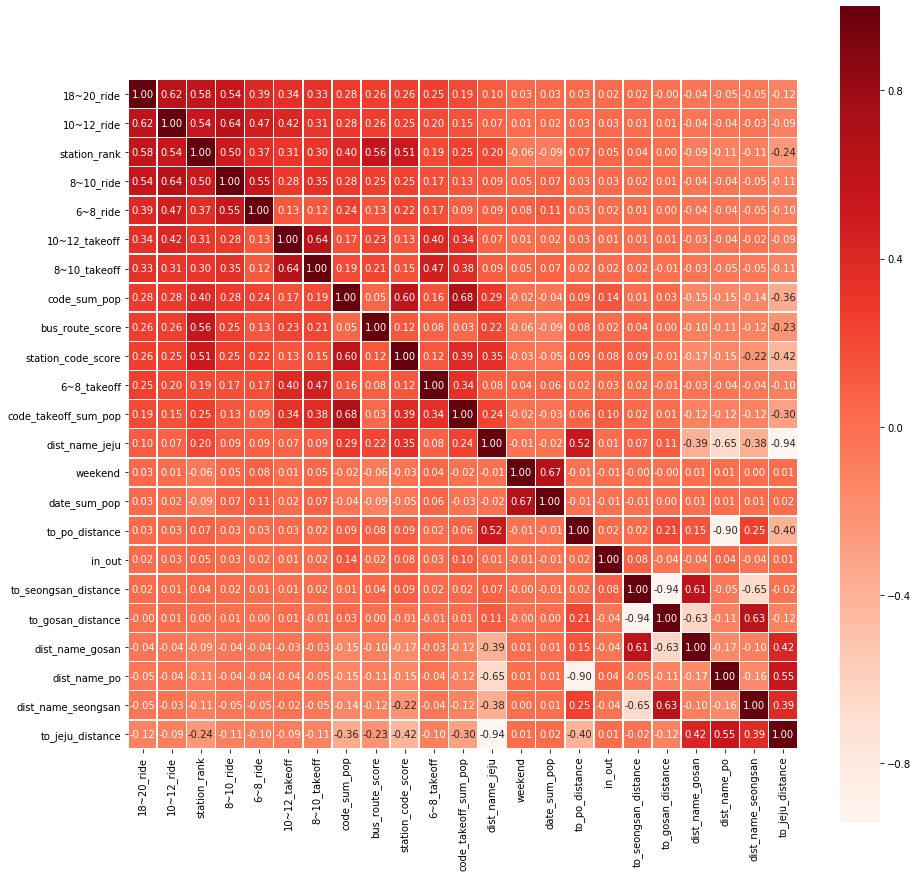

In [0]:
#상관관계 확인
corr_train = train[input_var + target]
k=corr_train.shape[1] #히트맵 변수 갯수
corrmat = corr_train.corr() #변수간의 상관관계
cols = corrmat.nlargest(k, '18~20_ride')['18~20_ride'].index # 제일 큰순서대로 20개를 뽑아냄
cm = np.corrcoef(corr_train[cols].values.T)
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(data = cm, annot=True, square=True, fmt = '.2f', linewidths=.5, cmap='Reds', 
            yticklabels = cols.values, xticklabels = cols.values)

In [0]:
X_train=train[input_var]
y_train=train[target]

X_test=test[input_var]

lightgbm과 xgboost는 별도로 학습

In [0]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=42))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))
forest = RandomForestRegressor(n_jobs = -1, max_features=3, min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=42)

models = [{'model' : lasso, 'name' : 'LASSO Regression'}, 
          {'model' : ENet, 'name' : 'Elastic Net Regression'}, 
         {'model' : forest, 'name' : 'RandomForset'}]

In [0]:
### cross-validation은 너무 오래 걸려서, 1차적으로 validation score확인하고 cross validation으로 넘어갈지 말지 판단 !!

def validate(models, X_train, y_train):
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state= 42)
  for m in models:
    modeling = m['model']
    modeling.fit(X_train, y_train)
    y_pred = modeling.predict(X_val)

    # 퇴근시간 인원이 0보다 작을 일은 없으므로 0보다 작으면 다 0으로 처리작업
    for i in range(len(y_pred)):
      if y_pred[i] < 0:
        y_pred[i] =0
    mse = np.sqrt(mean_squared_error(y_val, y_pred))
    # mse = np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

    print("Model {} RMSE : {:.4f}".format( m['name'], mse))

  return

In [0]:
%%time
validate(models, X_train, y_train)

Model LASSO Regression RMSE : 3.1539
Model Elastic Net Regression RMSE : 3.1539
Model RandomForset RMSE : 2.0746
CPU times: user 31.8 s, sys: 1.17 s, total: 33 s
Wall time: 17.3 s


In [0]:
def get_oof_lgbm(params, train_data, test_data, target_data, num_round, early_round, verbose_round, random_state=42):

    # FOLDs=KFold(n_splits=N_SPLITS, shuffle=True,random_state=random_state)

    oof = np.zeros(len(train_data))
    predictions = np.zeros(len(test_data))

    features_lgb = list(train_data.columns)
    feature_importance_df = pd.DataFrame()

    X_train, X_val, y_train, y_val = train_test_split(train_data, target_data, test_size = 0.25, random_state= 42)
    
    trn_data = lgb.Dataset(X_train, y_train)
    val_data = lgb.Dataset( X_val, y_val)

    num_round = num_round
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=verbose_round, 
                        early_stopping_rounds = early_round)
    y_pred = clf.predict(X_val, num_iteration=clf.best_iteration)

    for i in range(len(y_pred)):
      if y_pred[i] < 0:
        y_pred[i] =0
    mse = np.sqrt(mean_squared_error(y_val, y_pred))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_lgb
    fold_importance_df["importance"] = clf.feature_importance()
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions = clf.predict(test_data, num_iteration=clf.best_iteration)
    return y_pred, predictions, feature_importance_df, mse

In [0]:
lgb_params={"objective":"regression",
           "metric":"rmse",
           "alpha":0.08,
           "gamma":0.06,
           "eta":0.04,
           "silent":True}
lgb_val_pred,lgb_pred,lgb_importance, lgb_mse =get_oof_lgbm(lgb_params, X_train, X_test, y_train, num_round=100000, early_round=400, verbose_round=500, random_state=42)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 400 rounds.
[500]	training's rmse: 1.69387	valid_1's rmse: 2.05589
[1000]	training's rmse: 1.54567	valid_1's rmse: 2.05726
Early stopping, best iteration is:
[621]	training's rmse: 1.64845	valid_1's rmse: 2.05451


In [0]:
xgb_params={"objective":"reg:linear",
           "metric":"rmse",
           "alpha":0.08,
           "gamma":0.06,
           "eta":0.04,
           "silent":True}
xgb_oof,xgb_pred,xgb_importance,xgb_best_mean=get_oof_xgb(xgb_params, X_train, X_test, y_train, num_round=100000, early_round=400, verbose_round=500, N_SPLITS=5, random_state=42)


[0]	train-rmse:4.69516	valid-rmse:4.37798
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 400 rounds.
[500]	train-rmse:1.64246	valid-rmse:2.03864
[1000]	train-rmse:1.49583	valid-rmse:2.02984
Stopping. Best iteration:
[874]	train-rmse:1.52532	valid-rmse:2.02893

[0]	train-rmse:4.61631	valid-rmse:4.70692
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 400 rounds.
[500]	train-rmse:1.62051	valid-rmse:2.25813
[1000]	train-rmse:1.46678	valid-rmse:2.25648
Stopping. Best iteration:
[702]	train-rmse:1.54813	valid-rmse:2.25202

[0]	train-rmse:4.61408	valid-rmse:4.70974
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 400 rounds.
[500]	train-rmse:1.60089	valid-rmse:2.19369
[1000]	train-rmse:1.46468	valid-rmse:2.19089
Stopping. Best iteration:
[

퇴근시간 승차인원이 -인 경우는 없으므로 -인 경우는 다 0으로 변환

In [0]:
rf_X_train, X_val, rf_y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state= 42)
y_pred = forest.predict(X_val)

for i in range(len(y_pred)):
      if y_pred[i] < 0:
        y_pred[i] =0

y_pred

array([0.00890324, 2.38343631, 0.74974279, ..., 0.74108412, 1.55836121,
       0.13370837])

In [0]:
xgb_train, xgb_val = train_test_split(xgb_pred, test_size = 0.25, random_state= 42)
for i in range(len(xgb_val)):
      if xgb_val[i] < 0:
        xgb_val[i] =0

In [0]:
lgb_train, lgb_val = train_test_split(lgb_pred, test_size = 0.25, random_state= 42)
for i in range(len(lgb_val)):
      if lgb_val[i] < 0:
        lgb_val[i] =0

rmse를 최소화 하는 모델을 선택하여 Averaging Model로 사용

In [0]:
t = (xgb_val + lgb_val, y_pred)/3

In [0]:
#xgb + rf + lgb
np.sqrt(mean_squared_error(y_val, t))

2.0526756308046683

In [0]:
t = (xgb_val + y_pred)/2

In [0]:
#xgb + rf
np.sqrt(mean_squared_error(y_val, t))

2.0745259439717727

In [0]:
t = (lightgbm_val + y_pred)/2

In [0]:
#lightgbm + rf
np.sqrt(mean_squared_error(y_val, t))

2.0451649388999447

In [0]:
forest.fit(X_train, y_train)
rf_prediction = forest.predict(X_test)
for i in range(len(rf_prediction)):
      if rf_prediction[i] < 0:
        rf_prediction[i] =0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
for i in range(len(lgb_pred)):
      if lgb_pred[i] < 0:
        lgb_pred[i] =0

In [0]:
predictions = (lgb_pred + rf_prediction)/2

In [0]:
sub = pd.read_csv('data/submission_sample.csv')

In [0]:
sub['18~20_ride'] = predictions

In [0]:
sub.to_csv('CHA/submission_1206_1751.csv', index = False)